In [1]:
# detail data per team per season
# change score_hold to get different subset of the data
# 5 = 25%, 10 = 50%, 16 = 75%, 75 = 100%
import numpy as np
import pandas as pd

reg = pd.read_csv("data/RegularSeasonDetailedResults.csv")
reg['score_diff'] = abs(reg.Wscore - reg.Lscore)

score_hold = 75
data = reg[reg.score_diff<=score_hold]

## 把输赢队的技术统计分开
df1 = data[['Season','Daynum','Wteam','Wscore','Wfgm','Wfga','Wfgm3','Wfga3','Wftm','Wfta','Wor','Wdr','Wast','Wto','Wstl','Wblk','Wpf']].copy()
df2 = data[['Season','Daynum','Lteam','Lscore','Lfgm','Lfga','Lfgm3','Lfga3','Lftm','Lfta','Lor','Ldr','Last','Lto','Lstl','Lblk','Lpf']].copy()

dfw=df1.groupby(['Wteam',"Season"]).mean()
dfl=df2.groupby(['Lteam',"Season"]).mean()
dfw.head()

dfa = pd.concat([dfw, dfl], axis=1)
dfa = dfa.dropna()

dfa['score'] = dfa['Wscore'] + dfa['Lscore'];
dfa['fgm'] = dfa['Wfgm'] + dfa['Lfgm'];
dfa['fga'] = dfa['Wfga'] + dfa['Lfga'];
dfa['fgm3'] = dfa['Wfgm3'] + dfa['Lfgm3'];
dfa['fga3'] = dfa['Wfga3'] + dfa['Lfga3'];
dfa['ftm'] = dfa['Wftm'] + dfa['Lftm'];
dfa['fta'] = dfa['Wfta'] + dfa['Lfta'];
dfa['or'] = dfa['Wor'] + dfa['Lor'];
dfa['dr'] = dfa['Wdr'] + dfa['Ldr'];
dfa['ast'] = dfa['Wast'] + dfa['Last'];
dfa['to'] = dfa['Wto'] + dfa['Lto'];
dfa['stl'] = dfa['Wstl'] + dfa['Lstl'];
dfa['blk'] = dfa['Wblk'] + dfa['Lblk'];
dfa['pf'] = dfa['Wpf'] + dfa['Lpf'];

data0 = dfa[[-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]]

dfm=data0/2;
dfm = dfm.reset_index()

tour = pd.read_csv("data/TourneyCompactResults.csv")
tour = tour.rename(columns={"Wteam":"team1", "Lteam":"team2"})
# add a column of game results
tour["result"] = np.repeat(1,2050)
for i in range(2050):
    if tour.team1[i] > tour.team2[i]:       
        team1 = tour.team2[i]
        team2 = tour.team1[i]
        tour.set_value(i, "team1", team1)
        tour.set_value(i, "team2", team2)
        tour.set_value(i, "result", 0)
        
data = tour[[0,2,4,8]]
data = pd.merge(data, dfm, how='left', left_on=["team1","Season"], right_on=["level_0", "level_1"])
data = pd.merge(data, dfm, how='left', left_on=["team2","Season"], right_on=["level_0", "level_1"])

data = data.dropna()
data0 = data.drop(data.columns[[4,5,-15,-16]], axis=1)

target = data0['result']
df = data0.drop(data.columns[[0,1,2,3]], axis=1)

In [33]:
# finally we are ready to make some prediction
# import packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = train_test_split(df, target, random_state=0)

log = LogisticRegression().fit(x_train, y_train)
print(log.score(x_test,y_test));

pred = log.predict(x_test)
confusion = confusion_matrix(y_test,pred)
print(confusion);
print(precision_score(y_test,pred));
print(recall_score(y_test,pred));

logreg = LogisticRegression()
scores = cross_val_score(logreg, df, target, cv=5)
print(scores)

0.625550660793
[[75 41]
 [44 67]]
0.62037037037
0.603603603604
[ 0.5989011   0.65934066  0.6043956   0.54143646  0.61111111]


In [3]:
dfm.head()

,level_0,level_1,score,fgm,fga,fgm3,fga3,ftm,fta,or,dr,ast,to,stl,blk,pf
0,1101,2014,70.684211,22.868421,49.407895,5.921053,15.013158,19.026316,25.578947,7.776316,20.855263,10.671053,14.776316,7.657895,1.710526,20.644737
1,1101,2015,66.476190,23.285714,52.952381,8.071429,19.690476,11.833333,15.785714,8.214286,20.476190,13.142857,12.976190,6.047619,1.119048,20.500000
2,1101,2016,71.944444,24.277778,53.944444,6.861111,18.527778,16.527778,22.916667,8.250000,23.083333,13.138889,13.333333,7.138889,2.472222,22.888889
3,1101,2017,69.291667,24.343750,52.496528,7.232639,18.892361,13.371528,20.187500,7.631944,23.222222,13.590278,14.739583,7.072917,2.934028,22.100694
4,1102,2003,58.687500,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667


In [31]:
dfm.to_csv("detail_per_team_per_season_25%.csv")

In [35]:
t1102 = dfm[dfm.level_0 == 1102]

In [36]:
t1102

,level_0,level_1,score,fgm,fga,fgm3,fga3,ftm,fta,or,dr,ast,to,stl,blk,pf
4,1102,2003,58.687500,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667
5,1102,2004,55.325758,19.090909,42.750000,8.113636,23.045455,9.030303,13.212121,6.454545,14.500000,12.492424,11.530303,7.560606,2.106061,17.439394
6,1102,2005,60.556373,21.242647,48.022059,8.960784,24.892157,9.110294,12.531863,7.578431,15.071078,13.473039,10.144608,8.578431,1.715686,16.865196
7,1102,2006,61.500000,21.530303,46.272727,7.901515,21.613636,10.537879,14.378788,6.984848,16.712121,13.143939,11.560606,8.060606,1.765152,16.825758
8,1102,2007,65.159091,21.630682,46.875000,8.607955,23.312500,13.289773,17.500000,6.079545,19.318182,14.107955,10.352273,6.142045,1.357955,16.028409
9,1102,2008,57.571429,18.535714,42.392857,7.107143,18.928571,13.392857,19.285714,5.250000,21.357143,11.928571,12.678571,6.178571,1.785714,17.178571
10,1102,2009,61.038690,20.357143,44.395833,6.782738,16.901786,13.541667,19.860119,7.532738,21.702381,12.857143,13.574405,5.705357,2.235119,17.122024
11,1102,2010,59.723214,21.238095,45.985119,6.086310,17.877976,11.160714,17.178571,7.220238,21.065476,13.776786,12.470238,4.803571,1.627976,17.148810
12,1102,2011,64.250000,22.428571,47.857143,6.678571,17.750000,12.714286,18.142857,5.857143,22.428571,15.428571,11.928571,6.214286,2.535714,17.428571
13,1102,2012,61.286932,21.105114,47.056818,6.332386,18.954545,12.744318,18.522727,5.931818,22.704545,13.653409,13.028409,6.417614,2.968750,16.701705


In [7]:
% matplotlib inline
import matplotlib.pyplot as plt

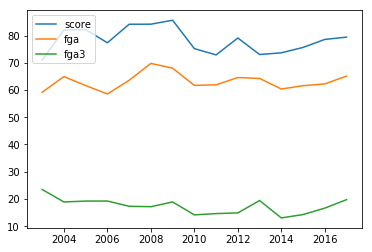

In [14]:
t1102 = dfm[dfm.level_0 == 1314]

plt.plot(t1102.level_1, t1102.score)
plt.plot(t1102.level_1, t1102.fga)
plt.plot(t1102.level_1, t1102.fga3)
# plt.plot(t1102.level_1, t1102.fta)
# plt.plot(t1102.level_1, t1102.dr)
# plt.plot(t1102.level_1, t1102.ast)
# plt.plot(t1102.level_1, t1102.to)
# plt.plot(t1102.level_1, t1102.stl)
# plt.plot(t1102.level_1, t1102.blk)
# plt.plot(t1102.level_1, t1102.pf)

plt.legend(['score', 'fga', 'fga3'], loc='upper left')

plt.show()

In [9]:
np.transpose(data0.head())

,1136,1137,1138,1139,1140
Season,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000
team1,1411.000000,1112.000000,1113.000000,1141.000000,1143.000000
team2,1421.000000,1436.000000,1272.000000,1166.000000,1301.000000
result,0.000000,1.000000,1.000000,1.000000,1.000000
score_x,71.666667,81.600000,74.452020,73.673913,73.172619
fgm_x,24.513889,29.153333,26.618687,24.728261,27.160714
fga_x,55.611111,68.920000,57.199495,52.742754,60.241071
fgm3_x,5.916667,6.873333,4.141414,6.275362,6.711310
fga3_x,18.750000,23.120000,13.073232,18.326087,18.068452
ftm_x,16.722222,16.420000,17.073232,17.942029,12.139881


In [5]:
tour.tail()

,Season,Daynum,team1,Wscore,team2,Lscore,Wloc,Numot,result
2045,2016,146,1314,88,1323,74,N,0,1
2046,2016,146,1393,68,1438,62,N,0,1
2047,2016,152,1314,83,1393,66,N,0,1
2048,2016,152,1328,95,1437,51,N,0,0
2049,2016,154,1314,77,1437,74,N,0,0


In [3]:
import pandas as pd
team = pd.read_csv("data/Teams.csv")

In [5]:
team[team.Team_Id == 1314]

,Team_Id,Team_Name
213,1314,North Carolina
